In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

In [2]:
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_1/data'
RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_1/results'
MODELS = ['ss', 'ss-sampler', 'ff']
COMPARISON_PARAMETERS = [
    'alpha',
    'beta',
    'beta_test',
    'segmentation',
    'sampler_feature_weight',
    'sampler_specificity'
]

# Model colors
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}

# Functions

In [3]:
def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def sigmoid(x):
    """
    Sigmoid function

    Arguments
    ---------
    x : int or float
        input value

    Returns
    -------
    float
        sigmoid of x
    """
    return 1 / (1 + np.exp(-x))

def round_up(x, n):
    """
    Round up to n decimal places

    Arguments
    ---------
    x : int or float
        input value
    n : int
        number of decimal places
    
    Returns
    -------
    float
        x rounded up to n decimal
    """
    factor = 10**n
    return np.ceil(x*factor)/factor


def plot_parameter_relationship(
    df,
    x,
    y,
    x_label = None,
    y_label = None,
    color = None
):
    """
    Plot relationship between two parameters

    Arguments
    ---------
    df : pandas.DataFrame
        data frame containing parameters
    x : str
        column name for x-axis
    y : str
        column name for y-axis
    x_label : str
        label for x-axis
    y_label : str
        label for y-axis
    color : str
        color for plot
    
    Returns
    -------
    None
    """

    # Init JointGrid
    g = sns.JointGrid(data=df, x=x, y=y, height=3)

    # Plot Logistic
    sns.regplot(
        data = df,
        x = x,
        y = y,
        logistic = True,
        color = color,
        scatter_kws = {'s': 1},
        line_kws = {'color': 'black'},
        ax = g.ax_joint,
    )

    # Plot histograms on the marginal axes
    g.plot_marginals(
        sns.histplot,
        color = color
    )
    g.set_axis_labels(x_label, y_label)

    # Print Pearson's and Spearman's correlations
    pear_val, pear_p = pearsonr(df[x], df[y])
    spear_val, spear_p = spearmanr(df[x], df[y])
    print(f"""
    {x} vs {y}
    Pearson's correlation: {np.round(pear_val, 2)} (p <= {round_up(pear_p, 4)})
    Spearman's correlation: {np.round(spear_val, 2)} (p <= {round_up(spear_p, 4)})
    """)


# Load Data
## Load Simulated Parameters

In [4]:
# Load simulated agent parameters
sim_params = []
for model in MODELS:
    for f in listdir(f'{DATA_PATH}/{model}/training'):
        if f.startswith('.'):
            continue
        agent_data = pd.read_csv(f'{DATA_PATH}/{model}/training/{f}')
        
        # Compute negative log likelihood of simulated choices
        agent_data['n_log_p'] = -np.log(agent_data['p'])
        agent_data = agent_data[[
            'id',
            'model_label',
            'n_log_p',
            *COMPARISON_PARAMETERS
        ]]
        agent_data = agent_data.groupby([
            'id',
            'model_label',
            *COMPARISON_PARAMETERS
        ])
        agent_data = agent_data.sum().reset_index()
        sim_params.append(agent_data.values[0])

# Combine into one data frame
sim_params = pd.DataFrame(
    sim_params,
    columns = ['id', 'model_label', *COMPARISON_PARAMETERS, 'nll']
)
sim_params

,id,model_label,alpha,beta,beta_test,segmentation,sampler_feature_weight,sampler_specificity,nll
0,1572,ss,0.536239,3.137813,3.137813,1.000000,1.0,1.0,50.025390
1,1214,ss,0.304338,7.141861,7.141861,1.000000,1.0,1.0,53.817826
2,1200,ss,0.076110,5.480844,5.480844,1.000000,1.0,1.0,91.556755
3,1566,ss,0.249710,3.764796,3.764796,1.000000,1.0,1.0,69.991549
4,1228,ss,0.509499,0.371635,0.371635,1.000000,1.0,1.0,90.799717
...,...,...,...,...,...,...,...,...,...
2995,420,ff,0.377560,0.688583,0.688583,0.355918,1.0,1.0,78.283219
2996,346,ff,0.638551,3.603255,3.603255,0.438119,1.0,1.0,27.766303
2997,408,ff,0.066764,0.080250,0.080250,0.994199,1.0,1.0,99.893782
2998,391,ff,0.273083,1.353837,1.353837,0.714501,1.0,1.0,60.321502


## Load Fitting Results

In [5]:
model_fits = []
for model in MODELS:
    this_model_fits = pd.read_csv(f'{RESULTS_PATH}/model_fits_{model}.csv')
    this_model_fits = this_model_fits[[
        'id',
        'model_label',
        'success',
        'nll', 
        'aic',
        'null_nll',
        *COMPARISON_PARAMETERS
    ]]
    model_fits.append(this_model_fits)
model_fits = pd.concat(model_fits)
model_fits = model_fits.reset_index(drop=True)
model_fits['null_aic'] = 2*model_fits['null_nll']
model_fits['null_fit'] = model_fits['null_aic'] < model_fits['aic']
for param in COMPARISON_PARAMETERS:
    colname = f'{param}_fit_at_bound'
    model_fits[colname] = 'no'
    idx = model_fits[param] < np.min(model_fits[param]) + .01
    model_fits.loc[idx, colname] = 'lo'
    idx = model_fits[param] > np.max(model_fits[param]) - .01
    model_fits.loc[idx, colname] = 'hi'
model_fits

,id,model_label,success,nll,aic,null_nll,alpha,beta,beta_test,segmentation,sampler_feature_weight,sampler_specificity,null_aic,null_fit,alpha_fit_at_bound,beta_fit_at_bound,beta_test_fit_at_bound,segmentation_fit_at_bound,sampler_feature_weight_fit_at_bound,sampler_specificity_fit_at_bound
0,1001,ff,True,290.444858,586.889716,299.439582,1.000000,0.039909,0.039909,0.905768,1.000000,1.000000,598.879164,False,hi,no,no,no,hi,lo
1,1001,ss,True,195.780559,395.561118,299.439582,1.000000,1.413750,1.413750,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo
2,1001,ss-sampler,True,293.419017,594.838035,299.439582,1.000000,0.303588,0.303588,1.000000,0.619048,1.000000,598.879164,False,hi,no,no,hi,no,lo
3,1002,ff,True,299.439202,604.878403,299.439582,0.000970,1.405941,1.405941,0.249287,1.000000,1.000000,598.879164,True,lo,no,no,no,hi,lo
4,1002,ss,True,296.900204,597.800407,299.439582,1.000000,0.087410,0.087410,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,999,ss,True,286.581194,577.162388,299.439582,1.000000,0.190320,0.190320,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo
8996,999,ss-sampler,True,251.719126,511.438253,299.439582,1.000000,0.308329,0.308329,1.000000,0.761166,4.630046,598.879164,False,hi,no,no,hi,no,no
8997,1000,ff,True,99.117147,204.234295,299.439582,0.857724,1.249325,1.249325,0.104573,1.000000,1.000000,598.879164,False,no,no,no,no,hi,lo
8998,1000,ss,True,292.859509,589.719018,299.439582,1.000000,0.048509,0.048509,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo


## Combine into one data frame

In [6]:
# Marge simulated and fit parameters
model_fits = pd.merge(
    sim_params,
    model_fits,
    on = 'id',
    suffixes = ('_sim', '_fit')
)

# Transform betas to be bounded [0, 1]
for param in COMPARISON_PARAMETERS:
    if ('beta' in param) or (param == 'sampler_specificity'):
        model_fits[f'{param}_trans_sim'] = sigmoid(model_fits[f'{param}_sim'])
        model_fits[f'{param}_trans_fit'] = sigmoid(model_fits[f'{param}_fit'])

model_fits

,id,model_label_sim,alpha_sim,beta_sim,beta_test_sim,segmentation_sim,sampler_feature_weight_sim,sampler_specificity_sim,nll_sim,model_label_fit,...,beta_test_fit_at_bound,segmentation_fit_at_bound,sampler_feature_weight_fit_at_bound,sampler_specificity_fit_at_bound,beta_trans_sim,beta_trans_fit,beta_test_trans_sim,beta_test_trans_fit,sampler_specificity_trans_sim,sampler_specificity_trans_fit
0,1572,ss,0.536239,3.137813,3.137813,1.000000,1.0,1.0,50.025390,ff,...,no,no,hi,lo,0.958426,0.518012,0.958426,0.518012,0.731059,0.731059
1,1572,ss,0.536239,3.137813,3.137813,1.000000,1.0,1.0,50.025390,ss,...,no,hi,hi,lo,0.958426,0.999957,0.958426,0.999957,0.731059,0.731059
2,1572,ss,0.536239,3.137813,3.137813,1.000000,1.0,1.0,50.025390,ss-sampler,...,no,hi,no,no,0.958426,0.526467,0.958426,0.526467,0.731059,0.999998
3,1214,ss,0.304338,7.141861,7.141861,1.000000,1.0,1.0,53.817826,ff,...,no,no,hi,lo,0.999209,0.593622,0.999209,0.593622,0.731059,0.731059
4,1214,ss,0.304338,7.141861,7.141861,1.000000,1.0,1.0,53.817826,ss,...,no,hi,hi,lo,0.999209,1.000000,0.999209,1.000000,0.731059,0.731059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,391,ff,0.273083,1.353837,1.353837,0.714501,1.0,1.0,60.321502,ss,...,no,hi,hi,lo,0.794756,0.551439,0.794756,0.551439,0.731059,0.731059
8996,391,ff,0.273083,1.353837,1.353837,0.714501,1.0,1.0,60.321502,ss-sampler,...,no,hi,no,lo,0.794756,0.620747,0.794756,0.620747,0.731059,0.731059
8997,385,ff,0.181693,0.547890,0.547890,0.283929,1.0,1.0,95.548166,ff,...,no,lo,hi,lo,0.633646,1.000000,0.633646,1.000000,0.731059,0.731059
8998,385,ff,0.181693,0.547890,0.547890,0.283929,1.0,1.0,95.548166,ss,...,no,hi,hi,lo,0.633646,0.528240,0.633646,0.528240,0.731059,0.731059


# Model Recovery

## Compute if the best fitting model matches the simulated model

In [7]:
model_comparison = model_fits[[
    'id',
    'model_label_sim',
    'model_label_fit',
    'aic'
]]

# Compute the minimum AIC for each agent
min_aic = model_comparison[['id', 'aic']].groupby('id').min()
min_aic = min_aic.reset_index()
model_comparison = pd.merge(
    model_comparison,
    min_aic,
    on = 'id',
    suffixes = ('', '_min')
)

# Identify the model with the lowest AIC
model_comparison['best_fit'] = (
    model_comparison['aic'] == model_comparison['aic_min']
).astype(int)

# Get best fitting models only
best_fits = model_comparison[model_comparison['best_fit'] == 1]
best_fits = best_fits.reset_index(drop=True) 

# Model is recovered if the best fit model matches the simulated model
best_fits['recovered'] = (
    (best_fits['model_label_sim'] == best_fits['model_label_fit']) &
    (best_fits['best_fit'] == 1)
).astype(int)

best_fits

,id,model_label_sim,model_label_fit,aic,aic_min,best_fit,recovered
0,1572,ss,ss,393.360702,393.360702,1,1
1,1214,ss,ss,399.264492,399.264492,1,1
2,1200,ss,ss,536.879298,536.879298,1,1
3,1566,ss,ss,448.293978,448.293978,1,1
4,1228,ss,ss,567.559472,567.559472,1,1
...,...,...,...,...,...,...,...
2995,420,ff,ff,448.004533,448.004533,1,1
2996,346,ff,ff,123.168624,123.168624,1,1
2997,408,ff,ss-sampler,602.679311,602.679311,1,0
2998,391,ff,ff,350.189144,350.189144,1,1


## Plot model recovery rates

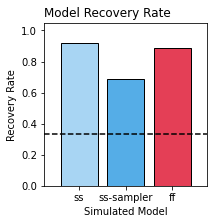

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = best_fits,
    x = 'model_label_sim',
    y = 'recovered',
    order = MODELS,
    ci = None,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.axhline(1/len(MODELS), color='black', linestyle='--')
ax.set_xlabel('Simulated Model')
ax.set_ylabel('Recovery Rate')
ax.set_xlim(-0.75, 2.75)
ax.set_ylim(0, 1.05)
ax.set_title('Model Recovery Rate', loc='left')
set_axis_ratio(ax)

## Fit rates for each model

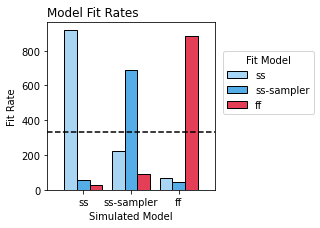

In [9]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.countplot(
    data = best_fits,
    x = 'model_label_sim',
    order = MODELS,
    hue = 'model_label_fit',
    hue_order = MODELS,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.axhline((len(best_fits)/3)/len(MODELS), color='black', linestyle='--')
ax.legend(title='Fit Model', loc=(1.05, .45))
ax.set_xlabel('Simulated Model')
ax.set_ylabel('Fit Rate')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Model Fit Rates', loc='left')
set_axis_ratio(ax)

## Fit rates for each model by aggregated AIC

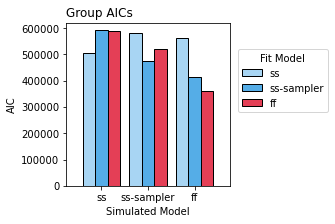

In [10]:
aic_comparison = model_comparison[['model_label_sim', 'model_label_fit', 'aic']]
aic_comparison = aic_comparison.groupby(['model_label_sim', 'model_label_fit'])
aic_comparison = aic_comparison.sum()
aic_comparison = aic_comparison.reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = aic_comparison,
    x = 'model_label_sim',
    y = 'aic',
    order = MODELS,
    hue = 'model_label_fit',
    hue_order = MODELS,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.legend(title='Fit Model', loc=(1.05, .45))
ax.set_xlabel('Simulated Model')
ax.set_ylabel('AIC')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Group AICs', loc='left')
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_64445/2262109917.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_aic_comparison['aic_diff'] = (


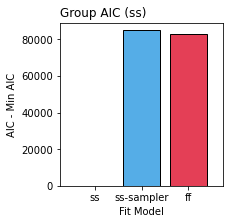

In [11]:
idx = aic_comparison['model_label_sim'] == 'ss'
ff_aic_comparison = aic_comparison[idx]

# Compute difference in AIC from the best fitting model
ff_aic_comparison['aic_diff'] = (
    ff_aic_comparison['aic'] - ff_aic_comparison['aic'].min()
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = ff_aic_comparison,
    x = 'model_label_fit',
    y = 'aic_diff',
    order = MODELS,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.set_xlabel('Fit Model')
ax.set_ylabel('AIC - Min AIC')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Group AIC (ss)', loc='left')
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_64445/2351578743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_aic_comparison['aic_diff'] = (


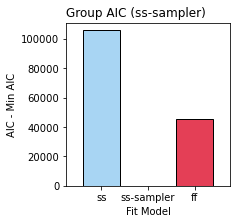

In [12]:
idx = aic_comparison['model_label_sim'] == 'ss-sampler'
ff_aic_comparison = aic_comparison[idx]

# Compute difference in AIC from the best fitting model
ff_aic_comparison['aic_diff'] = (
    ff_aic_comparison['aic'] - ff_aic_comparison['aic'].min()
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = ff_aic_comparison,
    x = 'model_label_fit',
    y = 'aic_diff',
    order = MODELS,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.set_xlabel('Fit Model')
ax.set_ylabel('AIC - Min AIC')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Group AIC (ss-sampler)', loc='left')
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_64445/2175725328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_aic_comparison['aic_diff'] = (


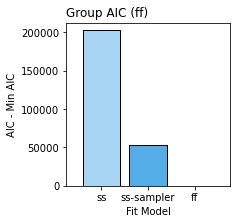

In [13]:
idx = aic_comparison['model_label_sim'] == 'ff'
ff_aic_comparison = aic_comparison[idx]

# Compute difference in AIC from the best fitting model
ff_aic_comparison['aic_diff'] = (
    ff_aic_comparison['aic'] - ff_aic_comparison['aic'].min()
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = ff_aic_comparison,
    x = 'model_label_fit',
    y = 'aic_diff',
    order = MODELS,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.set_xlabel('Fit Model')
ax.set_ylabel('AIC - Min AIC')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Group AIC (ff)', loc='left')
set_axis_ratio(ax)

# Parameter Recovery

## Conjunctive Model

### Learning Rate Recovery


    alpha_sim vs alpha_fit
    Pearson's correlation: 0.48 (p <= 0.0001)
    Spearman's correlation: 0.5 (p <= 0.0001)
    

    alpha_sim vs beta_trans_fit
    Pearson's correlation: 0.06 (p <= 0.0413)
    Spearman's correlation: 0.05 (p <= 0.0879)
    

    alpha_fit vs beta_trans_fit
    Pearson's correlation: -0.36 (p <= 0.0001)
    Spearman's correlation: -0.33 (p <= 0.0001)
    


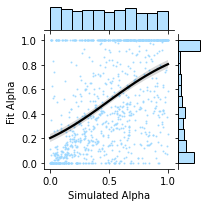

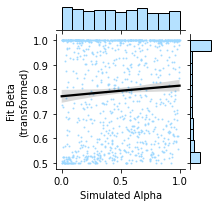

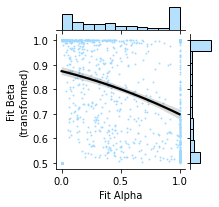

In [14]:
idx = (
    (model_fits['model_label_sim'] == 'ss') &
    (model_fits['model_label_fit'] == 'ss')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'alpha_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Alpha',
    color = MODEL_COLORS['ss']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'beta_trans_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'beta_trans_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss']
)

### Inverse Temperature Recovery


    beta_trans_sim vs beta_trans_fit
    Pearson's correlation: 0.64 (p <= 0.0001)
    Spearman's correlation: 0.59 (p <= 0.0001)
    


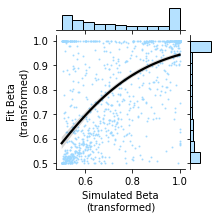

In [89]:
idx = (
    (model_fits['model_label_sim'] == 'ss') &
    (model_fits['model_label_fit'] == 'ss')
)
plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'beta_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss']
)

## Conjunctive Sampler Model

### Learning Rate Recovery


    alpha_sim vs alpha_fit
    Pearson's correlation: 0.31 (p <= 0.0001)
    Spearman's correlation: 0.32 (p <= 0.0001)
    

    alpha_sim vs beta_trans_fit
    Pearson's correlation: -0.06 (p <= 0.0667)
    Spearman's correlation: -0.13 (p <= 0.0001)
    

    alpha_sim vs sampler_feature_weight_fit
    Pearson's correlation: 0.13 (p <= 0.0001)
    Spearman's correlation: 0.13 (p <= 0.0001)
    

    alpha_sim vs sampler_specificity_trans_fit
    Pearson's correlation: -0.07 (p <= 0.0308)
    Spearman's correlation: -0.1 (p <= 0.0012)
    

    alpha_fit vs beta_trans_fit
    Pearson's correlation: -0.48 (p <= 0.0001)
    Spearman's correlation: -0.54 (p <= 0.0001)
    

    alpha_fit vs sampler_feature_weight_fit
    Pearson's correlation: -0.07 (p <= 0.0353)
    Spearman's correlation: -0.06 (p <= 0.0583)
    

    alpha_fit vs sampler_specificity_trans_fit
    Pearson's correlation: -0.12 (p <= 0.0002)
    Spearman's correlation: -0.16 (p <= 0.0001)
    


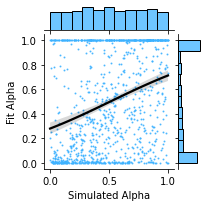

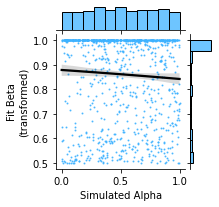

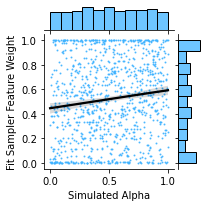

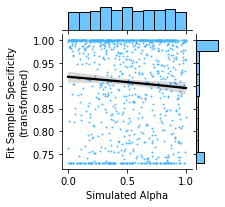

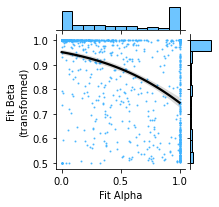

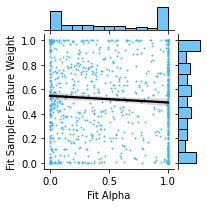

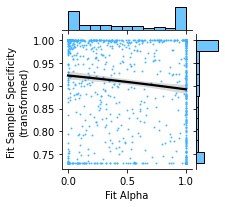

In [90]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'alpha_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Alpha',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'beta_trans_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'sampler_feature_weight_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'beta_trans_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'sampler_feature_weight_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'sampler_specificity_trans_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

### Inverse Temperature Recovery


    beta_trans_sim vs beta_trans_fit
    Pearson's correlation: 0.35 (p <= 0.0001)
    Spearman's correlation: 0.21 (p <= 0.0001)
    

    beta_trans_sim vs sampler_feature_weight_fit
    Pearson's correlation: 0.01 (p <= 0.7937)
    Spearman's correlation: 0.01 (p <= 0.7612)
    

    beta_trans_sim vs sampler_specificity_trans_fit
    Pearson's correlation: -0.12 (p <= 0.0003)
    Spearman's correlation: -0.19 (p <= 0.0001)
    

    beta_trans_fit vs sampler_feature_weight_fit
    Pearson's correlation: -0.14 (p <= 0.0001)
    Spearman's correlation: -0.13 (p <= 0.0001)
    

    beta_trans_fit vs sampler_specificity_trans_fit
    Pearson's correlation: 0.02 (p <= 0.5132)
    Spearman's correlation: 0.03 (p <= 0.2706)
    


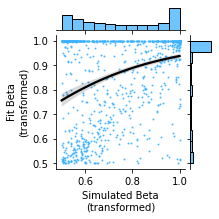

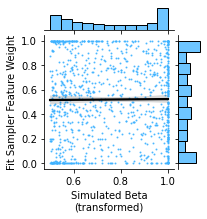

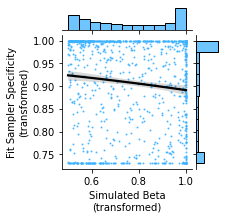

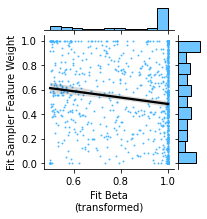

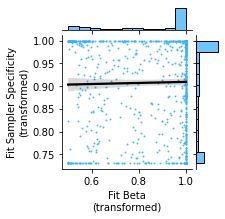

In [91]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'beta_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'sampler_feature_weight_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_fit',
    'sampler_feature_weight_fit',
    x_label = 'Fit Beta\n(transformed)',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_fit',
    'sampler_specificity_trans_fit',
    x_label = 'Fit Beta\n(transformed)',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

### Sampler Feature Weight


    sampler_feature_weight_sim vs sampler_feature_weight_fit
    Pearson's correlation: 0.59 (p <= 0.0001)
    Spearman's correlation: 0.59 (p <= 0.0001)
    

    sampler_feature_weight_sim vs sampler_specificity_trans_fit
    Pearson's correlation: -0.09 (p <= 0.0064)
    Spearman's correlation: -0.08 (p <= 0.0083)
    

    sampler_feature_weight_fit vs sampler_specificity_trans_fit
    Pearson's correlation: -0.03 (p <= 0.4206)
    Spearman's correlation: 0.03 (p <= 0.3353)
    


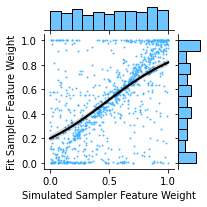

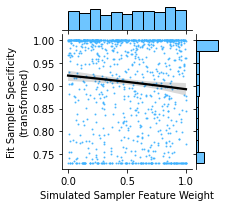

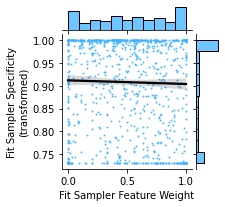

In [92]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_feature_weight_sim',
    'sampler_feature_weight_fit',
    x_label = 'Simulated Sampler Feature Weight',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_feature_weight_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Sampler Feature Weight',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_feature_weight_fit',
    'sampler_specificity_trans_fit',
    x_label = 'Fit Sampler Feature Weight',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

### Sampler Specificity


    sampler_specificity_trans_sim vs sampler_specificity_trans_fit
    Pearson's correlation: 0.46 (p <= 0.0001)
    Spearman's correlation: 0.41 (p <= 0.0001)
    


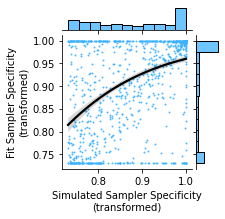

In [93]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_specificity_trans_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Sampler Specificity\n(transformed)',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

## Feature-Based Model

### Learning Rate Recovery


    alpha_sim vs alpha_fit
    Pearson's correlation: 0.59 (p <= 0.0001)
    Spearman's correlation: 0.58 (p <= 0.0001)
    

    alpha_sim vs beta_trans_fit
    Pearson's correlation: -0.03 (p <= 0.3047)
    Spearman's correlation: -0.06 (p <= 0.0538)
    

    alpha_sim vs segmentation_fit
    Pearson's correlation: 0.01 (p <= 0.6473)
    Spearman's correlation: 0.01 (p <= 0.7963)
    

    alpha_fit vs beta_trans_fit
    Pearson's correlation: -0.45 (p <= 0.0001)
    Spearman's correlation: -0.5 (p <= 0.0001)
    

    alpha_fit vs segmentation_fit
    Pearson's correlation: -0.02 (p <= 0.5842)
    Spearman's correlation: -0.02 (p <= 0.5988)
    


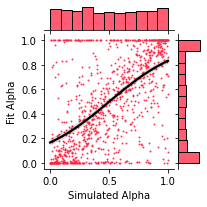

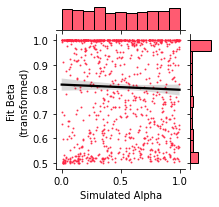

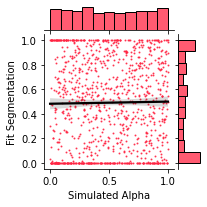

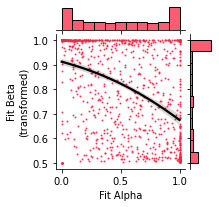

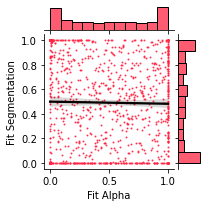

In [94]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'alpha_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Alpha',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'beta_trans_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'segmentation_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'beta_trans_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'segmentation_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)


### Inverse Temperature Recovery


    beta_trans_sim vs beta_trans_fit
    Pearson's correlation: 0.6 (p <= 0.0001)
    Spearman's correlation: 0.51 (p <= 0.0001)
    

    beta_trans_sim vs segmentation_fit
    Pearson's correlation: -0.0 (p <= 0.9741)
    Spearman's correlation: -0.0 (p <= 0.9296)
    

    beta_trans_fit vs segmentation_fit
    Pearson's correlation: 0.07 (p <= 0.035)
    Spearman's correlation: 0.1 (p <= 0.0018)
    


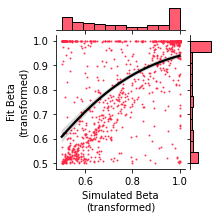

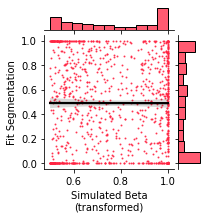

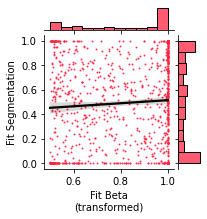

In [95]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'beta_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'segmentation_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_fit',
    'segmentation_fit',
    x_label = 'Fit Beta\n(transformed)',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)


### Segmentation Recovery


    segmentation_sim vs segmentation_fit
    Pearson's correlation: 0.65 (p <= 0.0001)
    Spearman's correlation: 0.63 (p <= 0.0001)
    


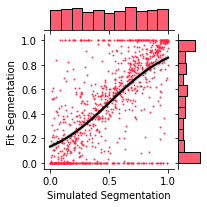

In [96]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'segmentation_sim',
    'segmentation_fit',
    x_label = 'Simulated Segmentation',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/4087428086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['alpha_at_lo_bound'] = plot_df['alpha_fit'] == np.min(plot_df['alpha_fit'])


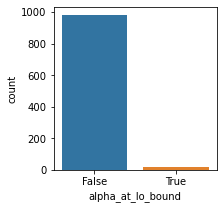

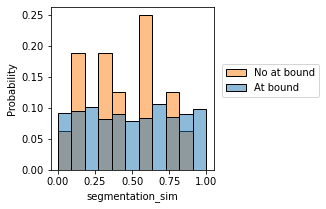

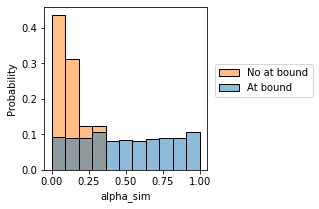

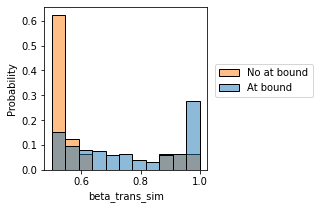

In [141]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['alpha_at_lo_bound'] = plot_df['alpha_fit'] == np.min(plot_df['alpha_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'alpha_at_lo_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'alpha_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'alpha_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'alpha_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/1748582661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['alpha_at_hi_bound'] = plot_df['alpha_fit'] == np.max(plot_df['alpha_fit'])


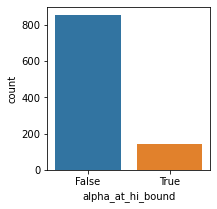

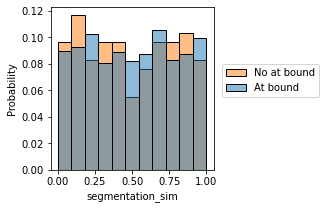

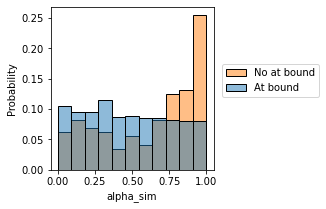

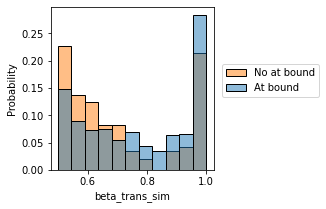

In [140]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['alpha_at_hi_bound'] = plot_df['alpha_fit'] == np.max(plot_df['alpha_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'alpha_at_hi_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'alpha_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'alpha_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'alpha_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/855376355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['segmentation_at_lo_bound'] = plot_df['segmentation_fit'] == np.min(plot_df['segmentation_fit'])


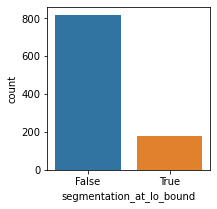

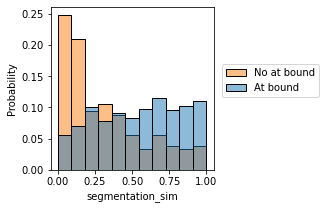

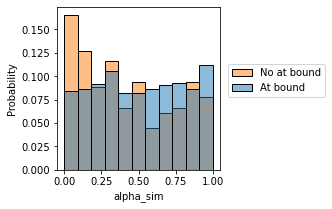

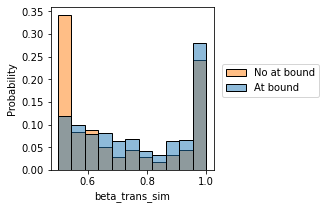

In [142]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['segmentation_at_lo_bound'] = plot_df['segmentation_fit'] == np.min(plot_df['segmentation_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'segmentation_at_lo_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'segmentation_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'segmentation_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'segmentation_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/475082918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['segmentation_at_hi_bound'] = plot_df['segmentation_fit'] == np.max(plot_df['segmentation_fit'])


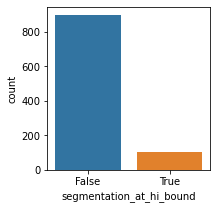

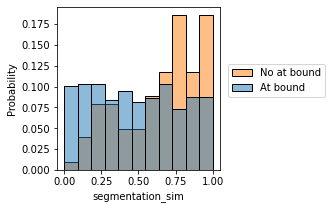

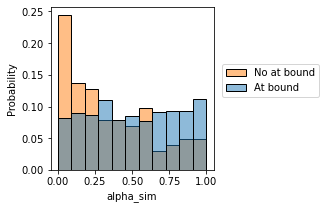

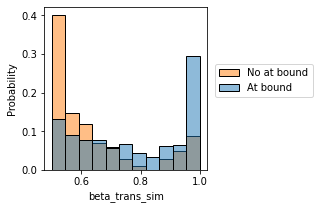

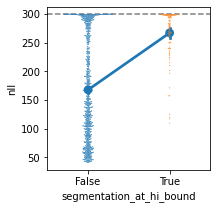

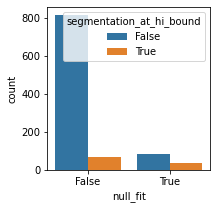

In [163]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['segmentation_at_hi_bound'] = plot_df['segmentation_fit'] == np.max(plot_df['segmentation_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'segmentation_at_hi_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'segmentation_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'segmentation_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'segmentation_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(plot_df['null_nll'].values[0], color='grey', linestyle='--', zorder=0)
sns.swarmplot(
    data = plot_df,
    x = 'segmentation_at_hi_bound',
    y = 'nll',
    s = 1,
    ax = ax
)
sns.pointplot(
    data = plot_df,
    x = 'segmentation_at_hi_bound',
    y = 'nll',
    ax = ax
)
set_axis_ratio(ax)

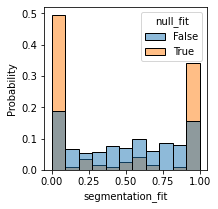

In [167]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = model_fits.loc[idx],
    x = 'segmentation_fit',
    hue = 'null_fit',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
set_axis_ratio(ax)

In [175]:
plot_df = model_fits.loc[idx, ['null_fit', 'segmentation_fit']]
plot_df['segmentation_at_bound'] = (
    (plot_df['segmentation_fit'] == np.max(plot_df['segmentation_fit'])) | 
    (plot_df['segmentation_fit'] == np.min(plot_df['segmentation_fit']))
)

both = np.sum(plot_df['null_fit'] & plot_df['segmentation_at_bound'])
both/np.sum(plot_df['segmentation_at_bound'])

0.3215547703180212

<AxesSubplot:xlabel='nll_sim', ylabel='nll_fit'>

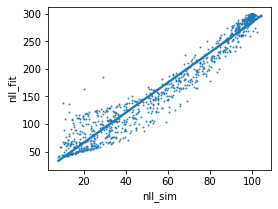

In [221]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

fig, ax = plt.subplots(figsize=(4, 3))
sns.regplot(
    data = model_fits.loc[idx],
    x = 'nll_sim',
    y = 'nll_fit',
    scatter_kws = {'s': 1},
    ax = ax
)

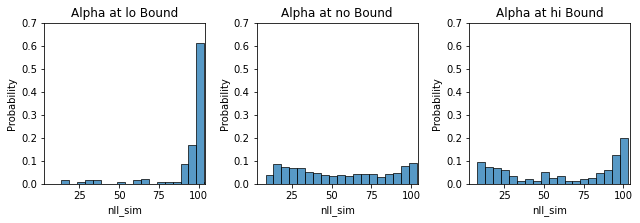

In [263]:


fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, bound_level in enumerate(['lo', 'no', 'hi']):
    ax = axs[i]
    idx = (
        (model_fits['model_label_sim'] == 'ff') &
        (model_fits['model_label_fit'] == 'ff') &
        (model_fits['alpha_fit_at_bound'] == bound_level) 
    )
    sns.histplot(
        data = model_fits.loc[idx],
        x = 'nll_sim',
        stat = 'probability',
        common_norm = False,
        binwidth = 5,
        ax = ax
    )
    ax.set_xlim(np.min(model_fits['nll_sim']), np.max(model_fits['nll_sim']))
    ax.set_ylim(0, .7)
    ax.set_title(f'Alpha at {bound_level} Bound')
    set_axis_ratio(ax)
fig.tight_layout()

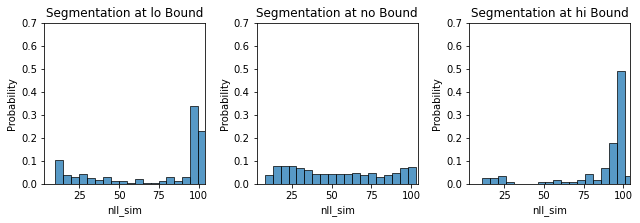

In [265]:


fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, bound_level in enumerate(['lo', 'no', 'hi']):
    ax = axs[i]
    idx = (
        (model_fits['model_label_sim'] == 'ff') &
        (model_fits['model_label_fit'] == 'ff') &
        (model_fits['segmentation_fit_at_bound'] == bound_level) 
    )
    sns.histplot(
        data = model_fits.loc[idx],
        x = 'nll_sim',
        stat = 'probability',
        common_norm = False,
        binwidth = 5,
        ax = ax
    )
    ax.set_xlim(np.min(model_fits['nll_sim']), np.max(model_fits['nll_sim']))
    ax.set_ylim(0, .7)
    ax.set_title(f'Segmentation at {bound_level} Bound')
    set_axis_ratio(ax)
fig.tight_layout()

In [270]:
np.sum([-np.log(.6)]*(72 + 144))

110.33833473345396